TODO:
- setup .venv
- get packets
- view dataset
- feature selections
- preprocessing
- pytorch NN
- Experiment with layers
- Try Activation functions
- See next


In [15]:
#Check GPU
!nvidia-smi

Fri Feb 14 21:07:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0             14W /   60W |     193MiB /   4096MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch 
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# Import libsss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# dataset was seperated before so let's see how the dataset looks like in the training csv
df = pd.read_csv('dataset/UNSW_NB15_testing-set.csv')

In [4]:
# check the informationn containing the datset
print("Dataset Shape:", df.shape) # (totaldata,features)
print("\nClass Distrubition:")
print(df['label'].value_counts(normalize=True)) # print how many benign and attack data and normalize to percentages

Dataset Shape: (82332, 45)

Class Distrubition:
label
1    0.5506
0    0.4494
Name: proportion, dtype: float64


In [5]:
# Check for missing values (none in this case)
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports   

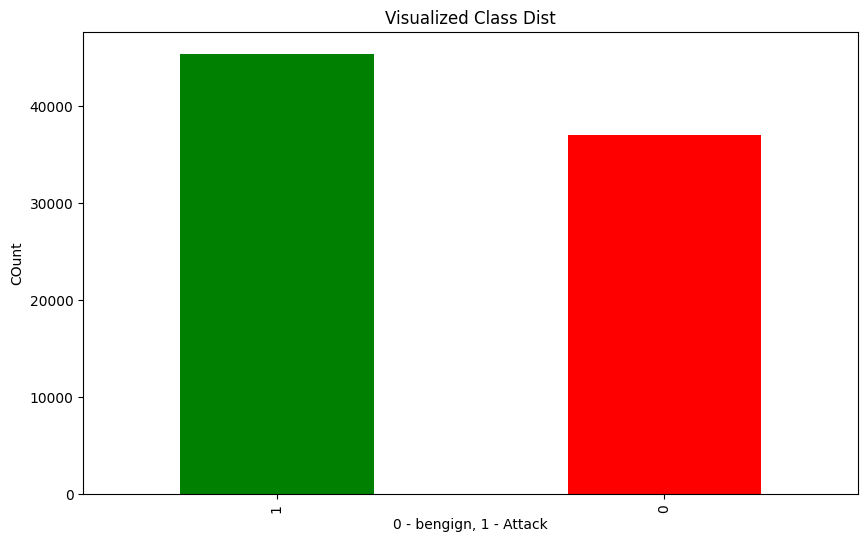

In [6]:
# Visualize the class distrobution
plt.figure(figsize=(10,6)) # size of the plot
df['label'].value_counts().plot(kind ='bar', color= ['green', 'red'])
plt.title('Visualized Class Dist')
plt.xlabel('0 - bengign, 1 - Attack')
plt.ylabel('COunt')
plt.show()

In [7]:
# see what types of attacks the dataset containst that have the label value of 1
if 'attack_cat' in df.columns:
    print("\nRelationship between labels and attack categories:")
    print(pd.crosstab(df['label'], df['attack_cat']))


Relationship between labels and attack categories:
attack_cat  Analysis  Backdoor   DoS  Exploits  Fuzzers  Generic  Normal  \
label                                                                      
0                  0         0     0         0        0        0   37000   
1                677       583  4089     11132     6062    18871       0   

attack_cat  Reconnaissance  Shellcode  Worms  
label                                         
0                        0          0      0  
1                     3496        378     44  


In [8]:
# Check for non numeric data
print("Types of data in our dataset: ")
print(df.dtypes)

# non numeric data that needs to be converted
categorical_collumns = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns if any:", categorical_collumns)

Types of data in our dataset: 
id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm  

Seperation For Bİnary Classification

In [9]:
# Seperate the features into the input and output
X = df.drop(['label', 'attack_cat'], axis = 1) # we also drop the atack_cat beacuase we want binary classification.
y = df['label'] # give the output the label as that is waht we want as output.

# y = ax+b think it like this way. X has inputs y has outputs

In [10]:
# convert remaining categorical features into numbers using one-hot encoding
X = pd.get_dummies(X, columns=['proto', 'service', 'state'])

In [11]:
# scale numbers for NN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

column_names = X.columns # get column names
X_scaled = scaler.fit_transform(X) # Scale Features
X = pd.DataFrame(X_scaled, columns= column_names) # COnvert back to dataframe 

# see results
print("Shape of the new db:", X.shape)

Shape of the new db: (82332, 191)


Shaping the NN

In [12]:
X_tensor = torch.FloatTensor(X.values)
y_tensor = torch.LongTensor(y.values)

print("X tensor shape:", X_tensor.shape)
print("y tensor shape:", y_tensor.shape)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

X tensor shape: torch.Size([82332, 191])
y tensor shape: torch.Size([82332])


In [13]:
class TrafficClasifier(nn.Module):
    def __init__(self, input_size):
        super(TrafficClasifier, self).__init__()

        # our very first layer - takes teh features and processes tehm
        self.layer1 = nn.Linear(input_size, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        # Second layer - further procesing
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Outuput layer - processes the binary classification
        self.output = nn.Linear(64, 2) # 2 beacause we have 2 classes

        # activation Function 
        self.relu = nn.ReLU()

    def forward(self,x):

        # First layer rpocessing
        x = self.layer1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # Second Layer processing
        x = self.layer2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        # Output layer
        x = self.output(x)

        return x
    
# Create model instance
input_size = X_tensor.shape[1] # Number of features
model = TrafficClasifier(input_size).to(device)

print("model Structure:")
print(model)

model Structure:
TrafficClasifier(
  (layer1): Linear(in_features=191, out_features=128, bias=True)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


In [16]:
# The teaching of the NN
criterion = nn.CrossEntropyLoss() # Measurers how wrong the predicitons are
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # optimizer + laerning rate

# dataloader to efficiently feet data to our model
dataset = TensorDataset(X_tensor, y_tensor)

# dataloader taht will handele batches
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# epochss
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader: 
        optimizer.zero_grad() # zero out any existing gradient

        outputs = model(batch_X)  #make predicitons

        loss = criterion(outputs, batch_y) # calculate how wrong predicitons are by comparing

        loss.backward() # calculate how to improve our predicts

        optimizer.step() # update models parameters

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1} / {epochs}], Loss: {avg_loss:.4f}')




Epoch [1 / 20], Loss: 0.0437
Epoch [2 / 20], Loss: 0.0435
Epoch [3 / 20], Loss: 0.0410
Epoch [4 / 20], Loss: 0.0415
Epoch [5 / 20], Loss: 0.0416
Epoch [6 / 20], Loss: 0.0399
Epoch [7 / 20], Loss: 0.0393
Epoch [8 / 20], Loss: 0.0385
Epoch [9 / 20], Loss: 0.0373
Epoch [10 / 20], Loss: 0.0380
Epoch [11 / 20], Loss: 0.0374
Epoch [12 / 20], Loss: 0.0356
Epoch [13 / 20], Loss: 0.0352
Epoch [14 / 20], Loss: 0.0358
Epoch [15 / 20], Loss: 0.0342
Epoch [16 / 20], Loss: 0.0351
Epoch [17 / 20], Loss: 0.0349
Epoch [18 / 20], Loss: 0.0345
Epoch [19 / 20], Loss: 0.0340
Epoch [20 / 20], Loss: 0.0340
